In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import suncalc

import dask.dataframe as dd
from pathlib import Path
import glob
import re

import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches

In [2]:
import sys

sys.path.append("../src")
sys.path.append("../src/activity")

In [3]:
import subsampling as ss
import activity_assembly as actvt
from core import SITE_NAMES, FREQ_GROUPS, SEATTLE_LATITUDE, SEATTLE_LONGITUDE

from cli import get_file_paths
import plot
import pipeline

In [4]:
POINT_CMAP = {0:'w',1:'r',2:'b',3:'g',4:'orange',5:'c',6:'pink',7:'k'}
POINT_CMAP

{0: 'w', 1: 'r', 2: 'b', 3: 'g', 4: 'orange', 5: 'c', 6: 'pink', 7: 'k'}

In [5]:
def get_time_on_for_dc_per_bin(clength_in_mins, time_on_in_mins, actvt_metric):
    slots = pd.date_range(actvt_metric.index[0], actvt_metric.index[-1], freq=f'1T', inclusive='left')
    dc_scheme = pd.DataFrame(index=slots)
    num_reps =np.floor(len(slots)/clength_in_mins).astype(int)
    time_ons = ([1]*time_on_in_mins + [0]*(clength_in_mins-time_on_in_mins)) * num_reps
    remaining_mins = (len(slots) - len(time_ons))
    if remaining_mins > 0:
        if remaining_mins > time_on_in_mins:
            dc_scheme['time_on_in_mins'] = time_ons + ([1]*time_on_in_mins + [0]*(remaining_mins-time_on_in_mins))
        else:
            dc_scheme['time_on_in_mins'] = time_ons + ([1]*remaining_mins)
    else:
        dc_scheme['time_on_in_mins'] = time_ons

    dc_scheme_on = dc_scheme.resample('30T').sum()
    dc_scheme_on['time_on_in_secs'] = dc_scheme_on['time_on_in_mins'] * 60
    dc_scheme_on['time_on_in_hours'] = dc_scheme_on['time_on_in_mins'] / 60
    return dc_scheme_on

In [6]:
def get_desired_metrics_from_activity_section(actvt_metric, data_params):
    c_lengths = []

    time_ons_per_dc = pd.DataFrame()
    high_actvt_metric = pd.DataFrame()
    for i, col_name in enumerate(data_params["dc_tags"]):
        dc_tag = re.search(r"\d+of\d+", col_name)[0]
        on = int(re.findall(r"\d+", dc_tag)[0])
        total = int(re.findall(r"\d+", dc_tag)[-1])
        dc_actvt = actvt_metric[f'{data_params["metric_tag"]} ({col_name})'].copy()
        if i > 0:
            c_lengths.append(total)

        dc_scheme_on = get_time_on_for_dc_per_bin(total, on, dc_actvt)
        time_ons_per_dc[f'time_on_in_mins ({dc_tag})'] = dc_scheme_on['time_on_in_mins']

        standard_metric = data_params['metric_tag']
        if data_params["metric_tag"]=='num_dets':
            standard_metric = 'call_rate_per_hour'
            rep_dc_actvt = dc_actvt / dc_scheme_on['time_on_in_hours']
        elif data_params["metric_tag"]=='bout_time':
            standard_metric = 'BTP'
            rep_dc_actvt = 100*(dc_actvt / dc_scheme_on['time_on_in_secs'])
        else:
            standard_metric = 'AI_per_hour'
            rep_dc_actvt = dc_actvt / dc_scheme_on['time_on_in_hours']

        high_actvt_metric[f'{standard_metric} ({col_name})'] = rep_dc_actvt

    high_actvt_desired_metrics = high_actvt_metric.copy()
    exp_dc_metrics = high_actvt_desired_metrics.iloc[:,1:]
    control_dc_metrics = high_actvt_desired_metrics.iloc[:,0]

    metrics = dict()
    metrics['time_ons_per_dc'] = time_ons_per_dc
    metrics['exp_metric'] = exp_dc_metrics
    metrics['control_metric'] = control_dc_metrics
    metrics['cycle_lengths'] = c_lengths

    return metrics

In [7]:
def plot_dc_control_comp_over_cycle(metrics, data_params):
    plot_key = data_params['type_tag']
    if data_params['type_tag']=='':
        plot_key = 'All'
    plt.figure(figsize=(4.8*len(data_params["percent_ons"]), 4*len(data_params["cycle_lengths"])))
    plt.rcParams.update({'font.size':12})
    plt.suptitle(f'{data_params["metric_tag"]} {data_params["site_tag"]} {plot_key} {data_params["start"]} to {data_params["end"]}', 
                        fontsize=24, y=1.01, weight='bold')
    for i in range(metrics['exp_metric'].shape[1]):
        plt.subplot(len(data_params["cycle_lengths"]),
                    len(data_params["percent_ons"]), i+1)
        
        single_col_dc_metr1 = pd.DataFrame(metrics['exp_metric'].iloc[:,i])
        single_col_c_metr = pd.DataFrame(metrics['control_metric'])
        plot_indiv_dc_control_comp_over_cycle(single_col_dc_metr1, single_col_c_metr, data_params)

    plt.tight_layout()
    plt.show()

def plot_indiv_dc_control_comp_over_cycle(single_col_dc_metr1, single_col_c_metr, data_params):
    dc_tag_split = re.findall(r"\d+", single_col_dc_metr1.columns[0])
    total = int(dc_tag_split[-1])
    single_col_dc_metr1.index = pd.DatetimeIndex(single_col_dc_metr1.index)
    dc_metr1 = pd.pivot_table(single_col_dc_metr1, index=(single_col_dc_metr1.index.time), 
                        columns=single_col_dc_metr1.index.date, 
                        values=single_col_dc_metr1.columns[0])
    dc_tag_split = re.findall(r"\d+", single_col_dc_metr1.columns[0])
    total = int(dc_tag_split[-1])
    dctag1 = re.search(r"\d+of\d+", single_col_dc_metr1.columns[0])[0]
    metrictag1 = (single_col_dc_metr1.columns[0]).split()[0]
    single_col_c_metr.index = pd.DatetimeIndex(single_col_c_metr.index)
    paired_col_c_metr = single_col_c_metr[(~single_col_dc_metr1.isna()).values]
    c_metr = pd.pivot_table(paired_col_c_metr, index=(paired_col_c_metr.index.time), 
                    columns=paired_col_c_metr.index.date, 
                    values=paired_col_c_metr.columns[0])
    plt.title(f'{dctag1} and continuous scheme')
    plt.plot([0, np.amax(c_metr)], [0, np.amax(c_metr)], linestyle='dashed', color='k')
    colors = np.tile(np.arange(0, c_metr.shape[0]),(c_metr.shape[1],1)).T
    labels = pd.to_datetime(c_metr.index, format='%H:%M:%S').strftime('%H:%M')
    sc = plt.scatter(c_metr, dc_metr1, c=colors, cmap='YlOrRd', edgecolors='k', s=50, alpha=0.8)
    cbar = plt.colorbar(sc, ticks=[0, colors.shape[0]-1])
    cbar.ax.set_yticklabels([labels[0], labels[-1]])
    plt.xlabel(f'Continuous Measured {metrictag1}')
    plt.xscale('log')
    plt.yscale('log')
    if (data_params['metric_tag'] == 'bout_time'):
        plt.xlim(1e-2, 1e2)
        plt.ylim(1e-2, 1e2)
    else:
        plt.xlim(1e-1, np.amax(c_metr))
        plt.ylim(1e-1, np.amax(c_metr))
    plt.ylabel(f'DC Measured {metrictag1}')
    plt.grid(which='both')

In [8]:
avail = np.arange(0, 720, 6) + 6
reset_24 = avail[np.where((24*60 % avail) == 0)[0]]
reset_24

array([  6,  12,  18,  24,  30,  36,  48,  60,  72,  90,  96, 120, 144,
       180, 240, 288, 360, 480, 720])

In [9]:
cycle_lengths = [6, 18, 30, 60, 144, 180]
percent_ons = [1/6, 1/3, 1/2, 2/3]
data_params = dict()
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
data_params['index_time_block_in_secs'] = '5'
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])

Carp LF


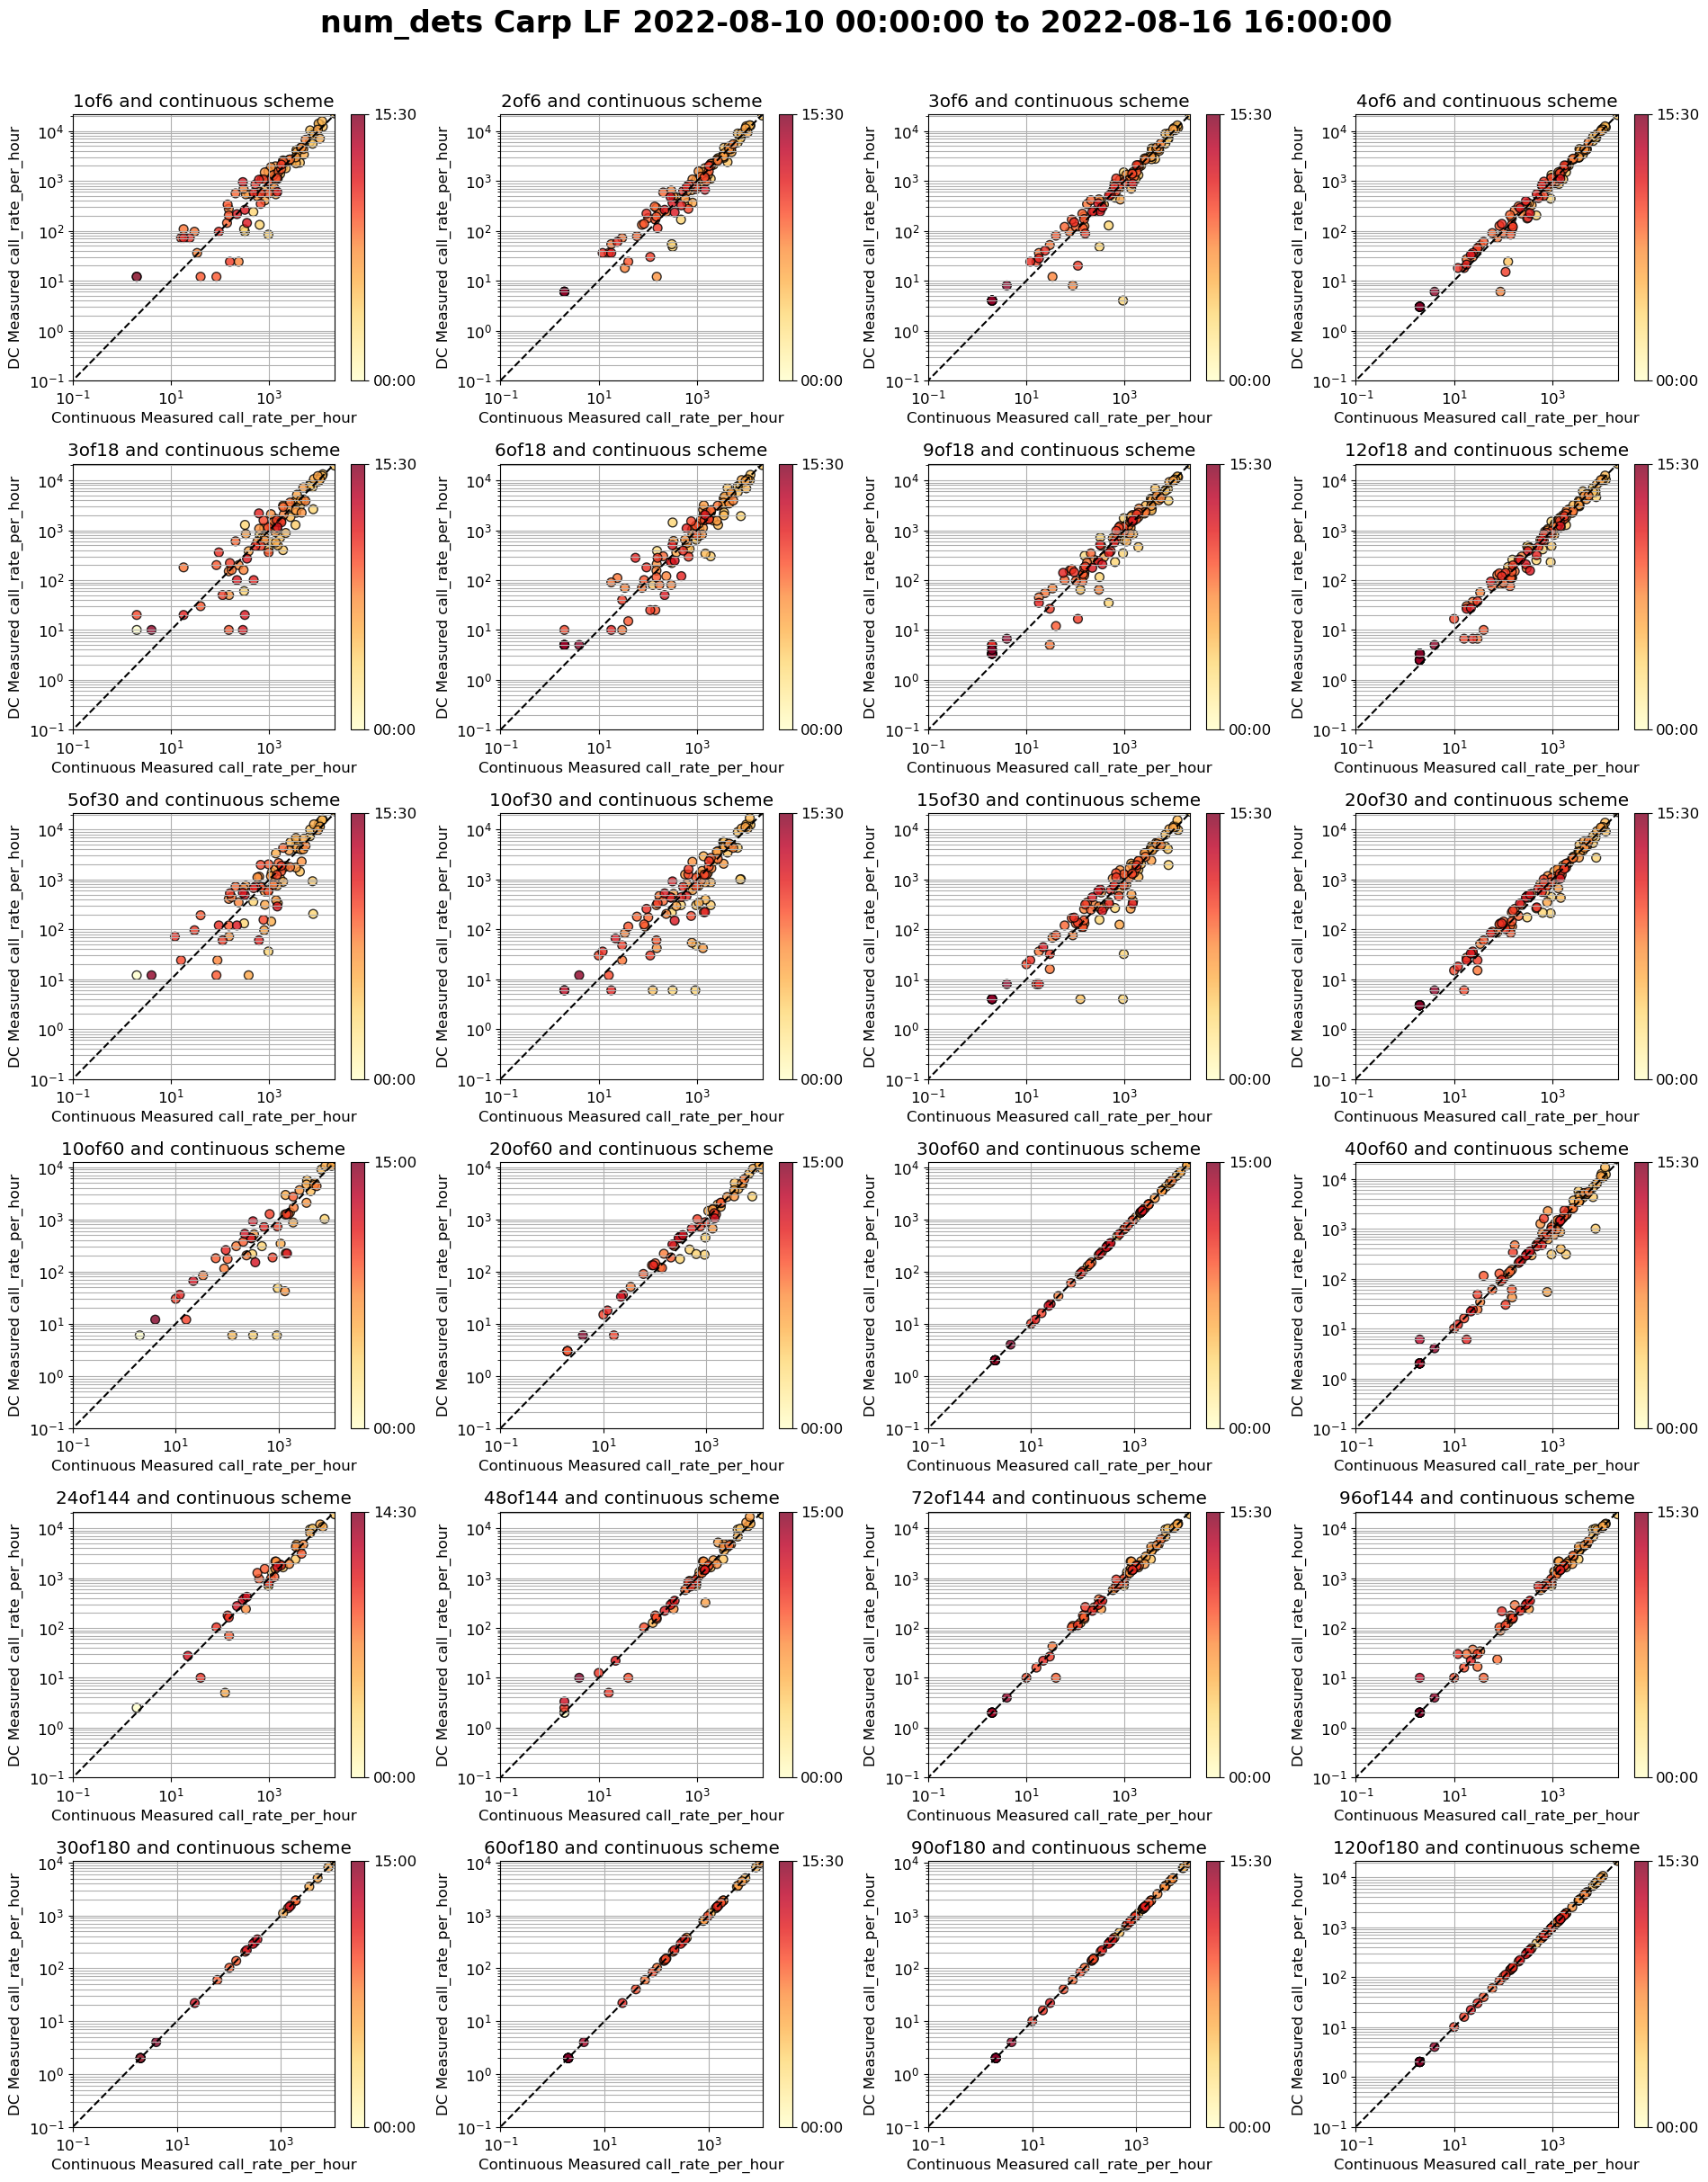

In [10]:
site_key = 'Carp'
type_keys = ['LF', 'HF']
data_params['bin_size'] = '30'
data_params["dc_tags"] = dc_tags
data_params["site_tag"] = site_key
data_params['cur_dc_tag'] = '30of30'
data_params["site_name"] = SITE_NAMES[site_key]

# for type_key in type_keys:
type_key = 'LF'
print(site_key, type_key)
data_params["type_tag"] = type_key
file_paths = get_file_paths(data_params)

data_params['metric_tag'] = 'num_dets'
activity_dets_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_dets_TYPE_SITE_summary"]}.csv', index_col=0)
activity_dets_arr.index = pd.DatetimeIndex(activity_dets_arr.index)
data_params['start'] = dt.datetime(2022, 8, 10, 0, 0, 0)
data_params['end'] = dt.datetime(2022, 8, 16, 16, 0, 0)
actvt_metric = activity_dets_arr.loc[data_params['start']:data_params['end']].copy()
metrics = get_desired_metrics_from_activity_section(actvt_metric, data_params)
plot_dc_control_comp_over_cycle(metrics, data_params)

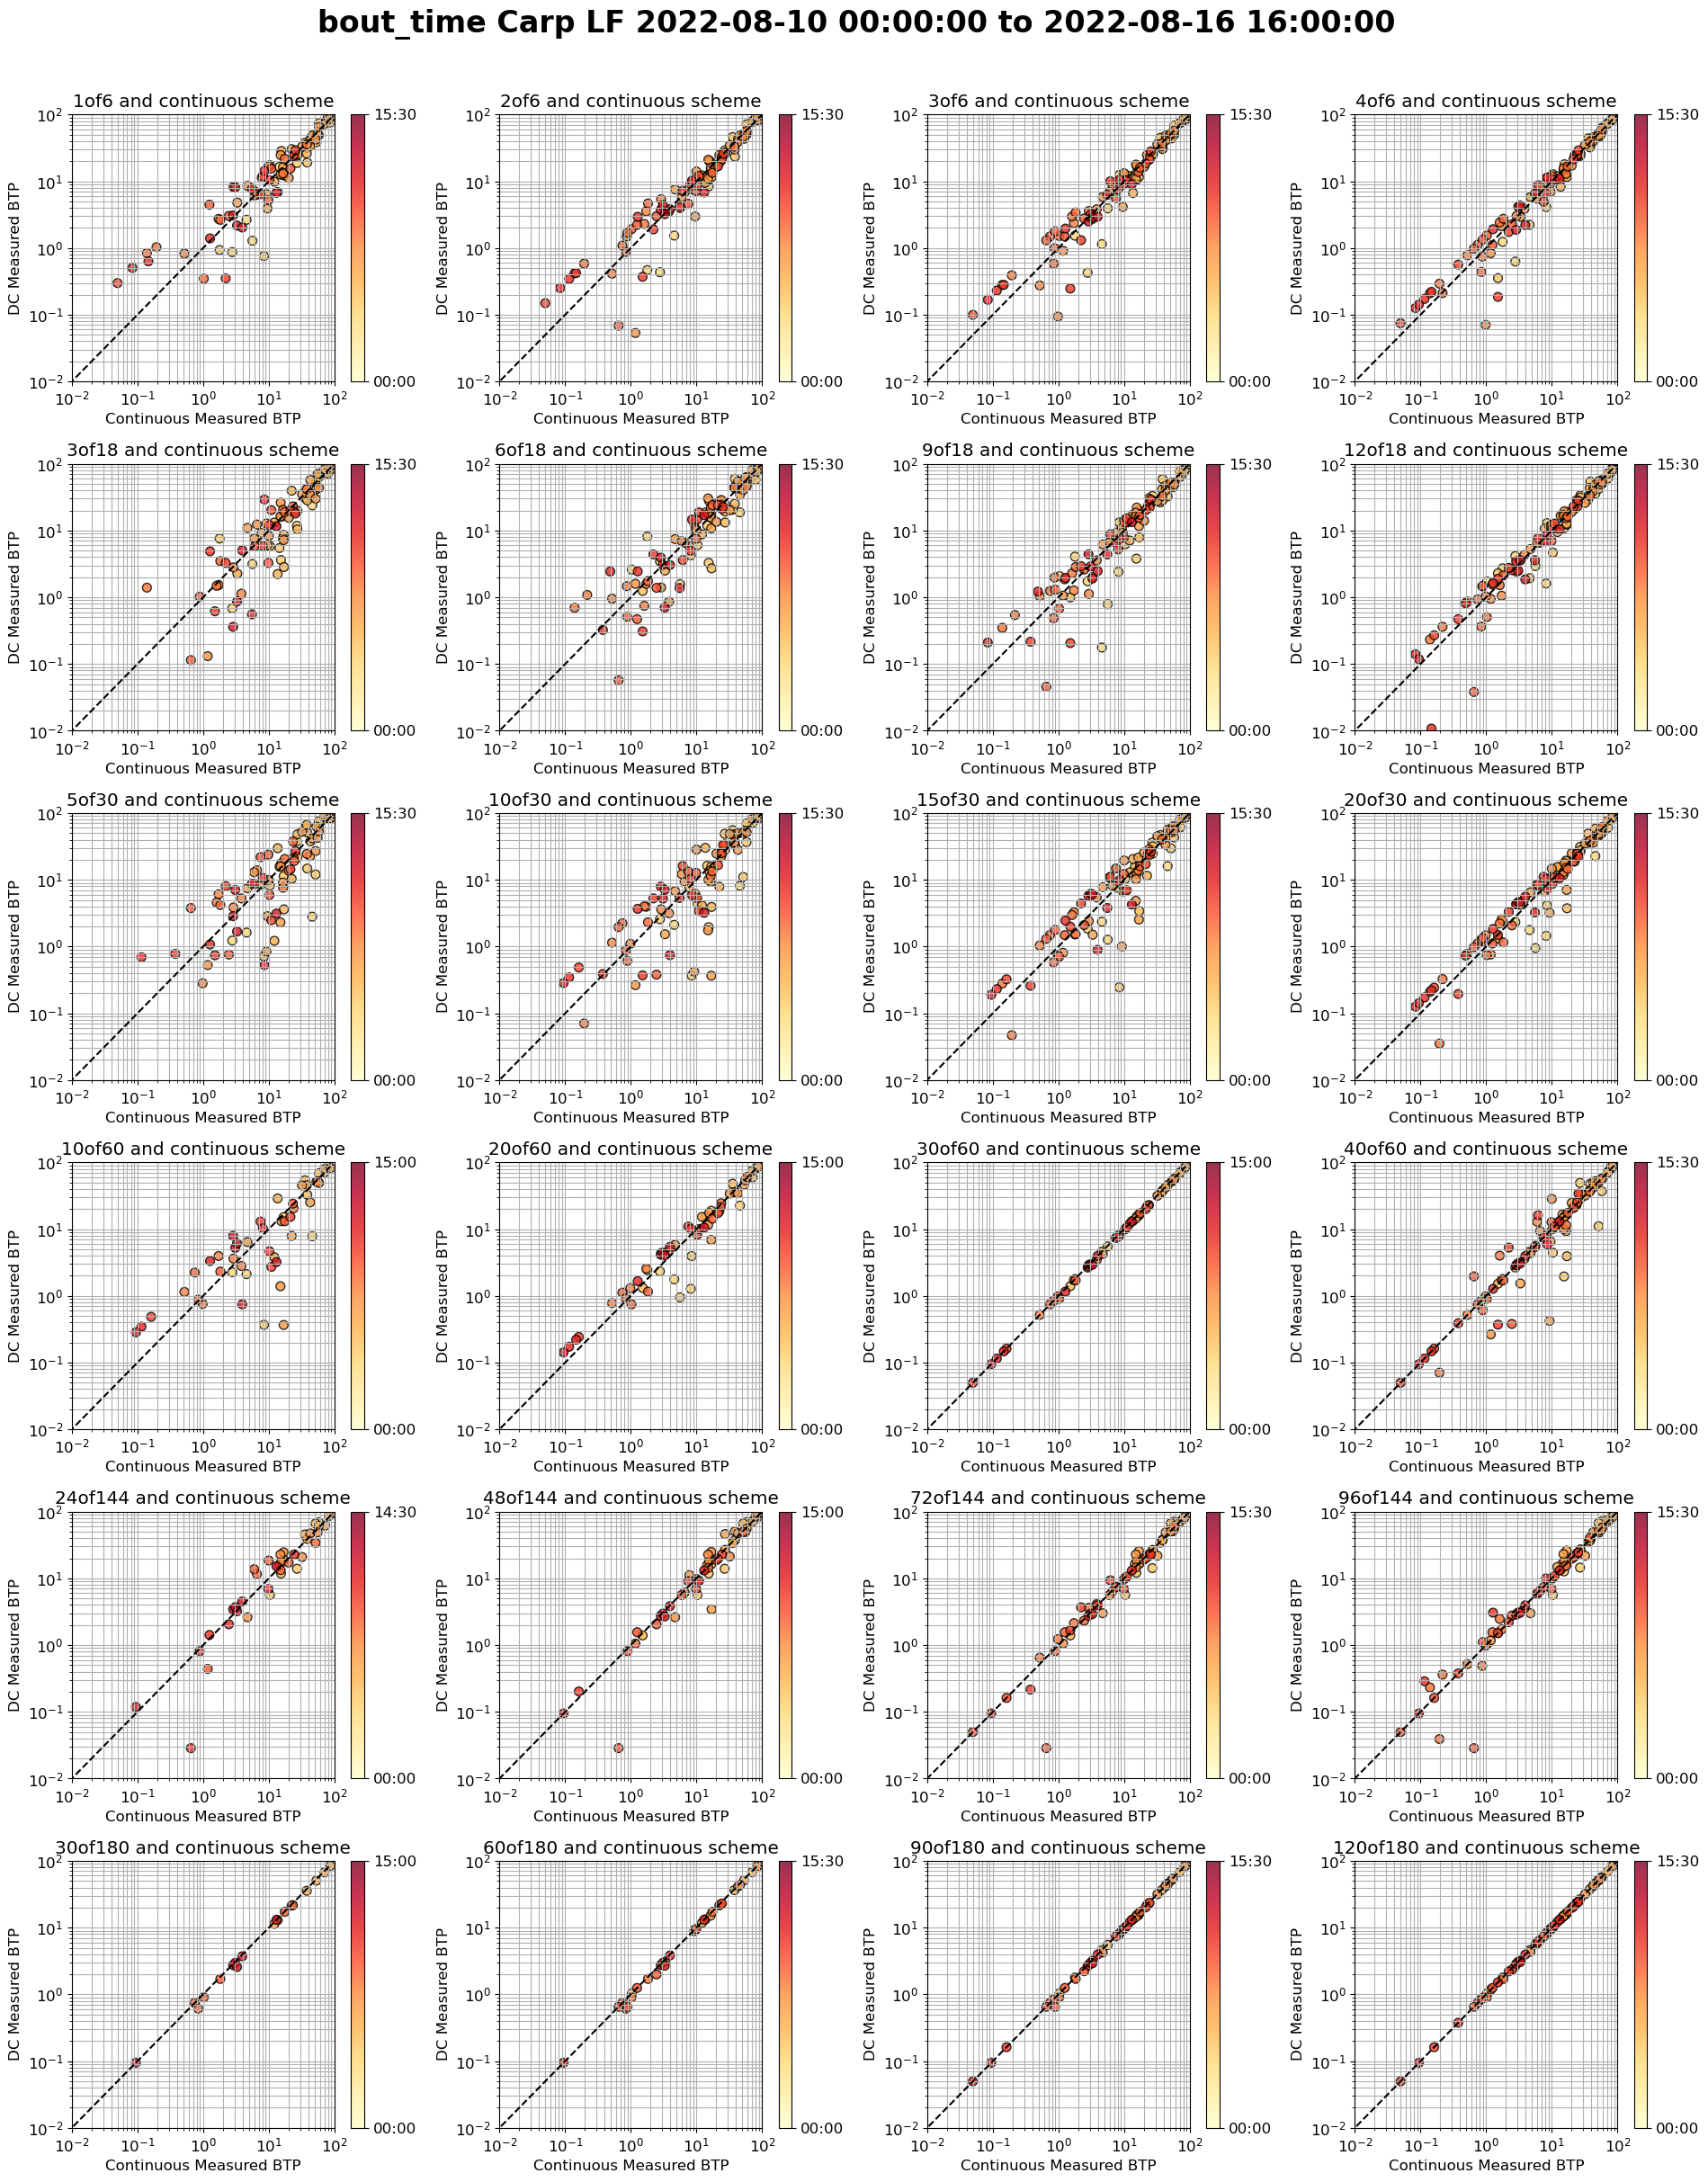

In [11]:
data_params['metric_tag'] = 'bout_time'
activity_bout_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_bouts_TYPE_SITE_summary"]}.csv', index_col=0)
activity_bout_arr.index = pd.DatetimeIndex(activity_bout_arr.index)
actvt_metric = activity_bout_arr.loc[data_params['start']:data_params['end']].copy()
metrics = get_desired_metrics_from_activity_section(actvt_metric, data_params)
plot_dc_control_comp_over_cycle(metrics, data_params)

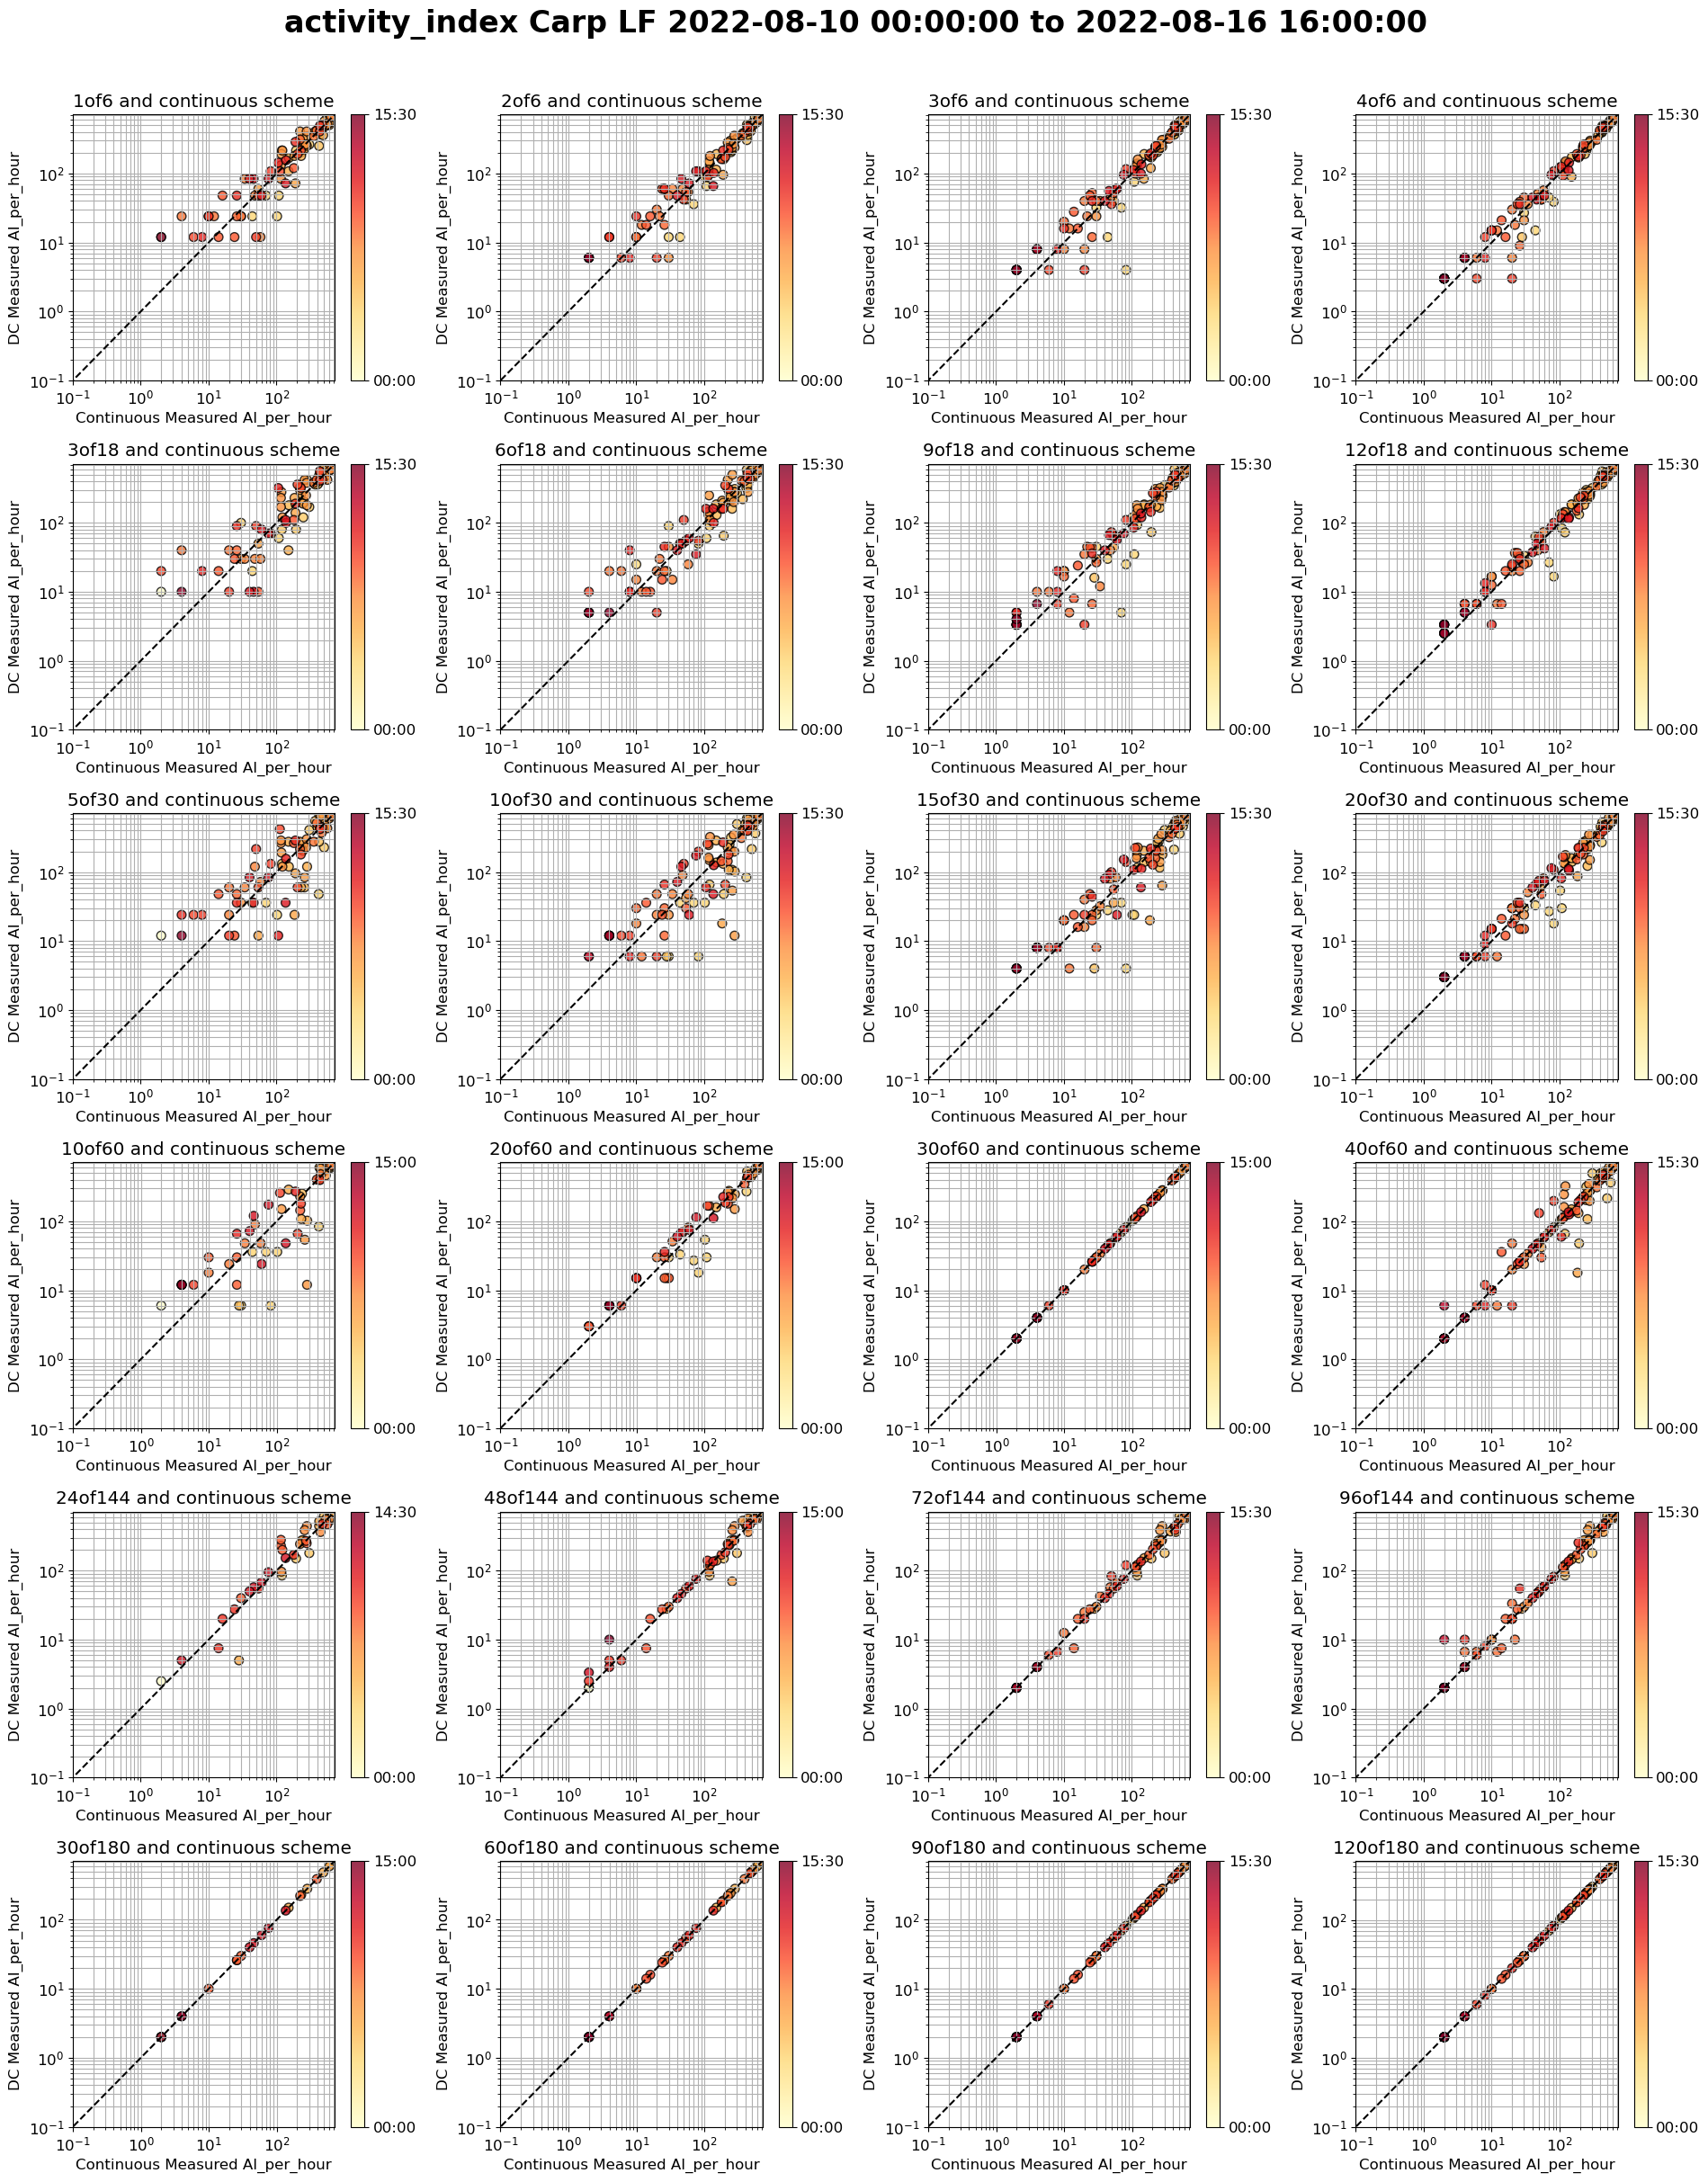

In [12]:
data_params['metric_tag'] = 'activity_index'
activity_inds_arr = pd.read_csv(f'{file_paths["duty_cycled_folder"]}/{file_paths["dc_inds_TYPE_SITE_summary"]}.csv', index_col=0)
activity_inds_arr.index = pd.DatetimeIndex(activity_inds_arr.index)
actvt_metric = activity_inds_arr.loc[data_params['start']:data_params['end']].copy()
metrics = get_desired_metrics_from_activity_section(actvt_metric, data_params)
plot_dc_control_comp_over_cycle(metrics, data_params)